v4: We've tried training without UD and DD columns - let's see what happens when we ignore H

In [1]:
# First, imports
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
# for Manhattan detector, need cityblock distance
from scipy.spatial.distance import cityblock
from itertools import zip_longest
# for plot formatting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
# Read in csv file and check what's inside
df = pd.read_csv('DSL-StrongPasswordData.csv')
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [3]:
subjects = df["subject"].unique()
print(subjects) 
# Confirmation there are 51 unique subjects

['s002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012' 's013'
 's015' 's016' 's017' 's018' 's019' 's020' 's021' 's022' 's024' 's025'
 's026' 's027' 's028' 's029' 's030' 's031' 's032' 's033' 's034' 's035'
 's036' 's037' 's038' 's039' 's040' 's041' 's042' 's043' 's044' 's046'
 's047' 's048' 's049' 's050' 's051' 's052' 's053' 's054' 's055' 's056'
 's057']


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


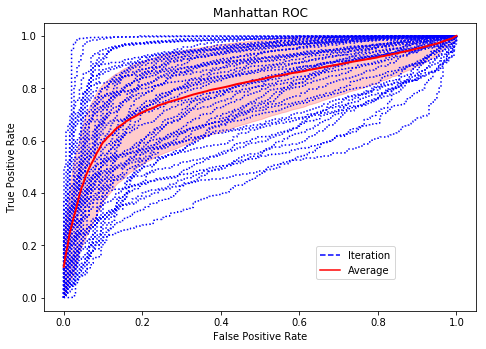

In [4]:
# store the eer of each iterative model in list - from which the mean can be calculated later
eer_list = []

fig = plt.figure()

# Since for each iteration, roc_curve returns fpr and tpr values of different lengths, to obtain an average ROC
# we define set fpr thresholds, and interpolate the tpr values of each model at each point in the array.
fpr_thresh = np.linspace(0,1,201)
interp_tpr_lst = []

for subject in subjects:
    real_user = df.loc[df.subject == subject]
    fake_user = df.loc[df.subject != subject]

    # We train our model using a genuine user's data
    # Since DD is correlated to UD and H, let's drop DD and train to see if performance improves (through reduced bias)

    training_data = real_user[:200].loc[:, 'H.period':'H.Return']
    training_data.drop(list(training_data.filter(regex = 'H')), axis = 1, inplace = True)
    
    # To test our model, we need both more data from the original user, and imposter user data
    genuine_user_data = real_user[200:].loc[:, 'H.period':'H.Return']
    genuine_user_data.drop(list(genuine_user_data.filter(regex = 'H')), axis = 1, inplace = True)

    imposter_user_data = fake_user[:].loc[:, 'H.period':'H.Return']
    imposter_user_data.drop(list(imposter_user_data.filter(regex = 'H')), axis = 1, inplace = True)

    
    # Let's check dimensions of our training and testing tuples are the same...just in case
    if training_data.shape != genuine_user_data.shape:
        sys.exit("training_data and genuine_user_data shapes don't match: {} | {}".format(training_data.shape, genuine_user_data.shape))
    elif imposter_user_data.shape[0] != genuine_user_data.shape[0]*100:
        sys.exit("imposter_user_data and genuine_user_data rows aren't 20000 and 200: {} | {}".format(imposter_user_data.shape[0], genuine_user_data.shape[0]))

    # Train
    mean_vector = training_data.mean().values # store mean vector in a numpy array to use with cityblock func below
    
    # Test - for each row (entry), compute cityblock distance between mean vector and test vector
    user_dists = []
    imposter_dists = []
    for i in range(genuine_user_data.shape[0]):
        dist = cityblock(genuine_user_data.iloc[i].values, mean_vector)
        user_dists.append(dist)

    for i in range(imposter_user_data.shape[0]):
        dist = cityblock(imposter_user_data.iloc[i].values, mean_vector)
        imposter_dists.append(dist)
        
    # Evaluate - compute equal error rates
    # Labels: 0 = user, 1 = imposter. We therefore need np arrays of 0s and 1s to same length as NSamples
    labels = [0]*len(user_dists) + [1]*len(imposter_dists)
    fpr, tpr, thresholds = roc_curve(labels, user_dists + imposter_dists) 

    # add roc curve of each model iteration to a pre-created figure
    # TODO add unique label to each axes we create here to suppress the annoying warning
    ax = fig.add_axes([0,0,1,1])
    ax.plot(fpr,tpr,'blue',ls=':',label=subject)

    # TPR = TP / (TP + FN) i.e. over total positives that shouldve been identified as true
    # FPR = FP / (FP + TN) i.e. over total negatives that shouldve been identified as true
    # TPR + FNR = 1
    # FPR + TNR = 1
    fnr = 1 - tpr
    
    # Equal error rate is where fnr = fpr (or minimum distance between them)      
    # So we calculate the absolute difference between fnr and fpr and find where that's minimised
    # Small differences are present depending on whether we do fnr[] or fpr[] as we aren't interpolating
    eer = fnr[np.nanargmin(np.absolute(fnr-fpr))]
    eer_list.append(eer)
    
    interp_tpr_lst.append(np.interp(fpr_thresh,fpr,tpr))

mean_tpr = np.mean(interp_tpr_lst,axis=0)  
std_tpr = np.std(interp_tpr_lst,axis=0)

# for error bar propagation
up_tpr = np.minimum(mean_tpr + std_tpr, 1) #mean_tpr + std_tpr 
low_tpr = mean_tpr - std_tpr

ax = fig.add_axes([0,0,1,1])
ax.set_title('Manhattan ROC')
ax.plot(fpr_thresh,mean_tpr,'red',ls='-',lw=2,label='Average')
ax.fill_between(fpr_thresh, low_tpr, up_tpr, color='red', alpha=0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
leg_iter = mlines.Line2D([],[],color='blue',linestyle="--",label='Iteration')
leg_av = mlines.Line2D([],[],color='red',linestyle="-",label='Average')
fig.legend(loc=[0.65,0.2],handles=[leg_iter,leg_av])

In [5]:
# Compute average eer
print("Manhattan average equal error rate = {}".format(np.mean(eer_list)))
print("Manhattan corresponding standard deviation = {}".format(np.std(eer_list, ddof=0)))

Manhattan average equal error rate = 0.25396274509803923
Manhattan corresponding standard deviation = 0.12705377425818074


# Comments on Manhattan No H
The average equal error rate has been increased with respect to the nominal case by 16.17%.
So this was a bad idea!